# Велорух у Києві

Згідно до прийнятої Київрадою [Стратегії розвитку Києва до 2025 року](https://dei.kyivcity.gov.ua/files/2017/7/28/Strategy2025new.pdf), через $5$ років поїздки на велосипеді мають складати $5\%$ від всіх поїздок містом. Але як взагалі зрозуміти, скільки відсотків поїздок здійснюється на велосипеді? В $2015$ році було створено [транспортну модель Києва](https://apluss.pro/nashi-proektu/transportna-model-m-kiieva/), в рамках якої проводилось опитування мобільності, але після цього статистика про велопоїздки в Києві офіційно не збиралась. Єдине джерело цієї статистики зараз - [підрахунок велосипедистів громадською організацією Ucycle](https://u-cycle.org.ua/projects/pidrakhunok-velosypedystiv/). На жаль, ручні підрахунки мають свої обмеження - наприклад, їх результат сильно залежить від погоди. Щоб розв'язати цю проблему, муніципалітети розвинених міст часто встановлюють [автоматичні датчики велосипедистів](http://www.bikearlington.com/counter-data/), що працюють цілодобово.

Резюмуючи, в Києві проблема з даними про велорух. Я спробую розглянути доступні дані та зробити з них якісь висновки.

## Безпека велосипедистів на дорогах

Я використовуватиму [статистику Нацполіції про ДТП в Києві між сепнем $2016$ та груднем $2019$](https://docs.google.com/spreadsheets/d/1Dk-oB-lXYNFzSMGUtO4iSUnYMWmLQnH9/edit#gid=291616867). Вона була отримана на запит [киянином Сергієм Пасютою](https://www.facebook.com/pasyuta/posts/3676095249072190) (на жаль, у відкритий доступ Нацполіція [викладає](http://patrol.police.gov.ua/statystyka/) набагато більш агреговану і, відповідно, набагато менш придатну для використання статистику). Дивіться [мій минулий пост](https://nbviewer.jupyter.org/github/DmytroTym/urban/blob/master/Road%20safety%20measures%20analysis%20Kyiv.ipynb) для прикладу того, як ці дані можна використовувати для оцінки ефективності конкретних рішень. Зараз же подивимося саме на велоДТП.

In [1]:
import pandas as pd
import numpy as np

crash_data = pd.read_csv('DTP Kyiv 2016-2019.csv')

In [2]:
#тут рахуємо і виводимо, якою саме є частка велосипедистів у структурі смертей, важких та легких травм на дорогах
cyclists = ['Велосипедист', 'Пасажир велосипеда']
death_labels = ['Помер на місці ДТП', 'Помер по дорозі в лікарню', 'Помер у лікарні протягом 30 діб']
injuries = death_labels + ['Легко травмований', 'Тяжко травмований']

cyclist_deaths = len(crash_data.loc[crash_data['person'].isin(cyclists) & crash_data['injury'].isin(death_labels)].index)
overall_deaths = len(crash_data.loc[crash_data['injury'].isin(death_labels)].index)
cyclist_hard = len(crash_data.loc[crash_data['person'].isin(cyclists) & (crash_data['injury'] == 'Тяжко травмований')].index)
overall_hard = len(crash_data.loc[crash_data['injury'] == 'Тяжко травмований'].index)
cyclist_light = len(crash_data.loc[crash_data['person'].isin(cyclists) & (crash_data['injury'] == 'Легко травмований')].index)
overall_light = len(crash_data.loc[crash_data['injury'] == 'Легко травмований'].index)

print('''Смерті велосипедистів: {} з {} смертей всього ({:.2f} %)
Тяжкі травми велосипедистів: {} з {} тяжких травм всього ({:.2f} %)
Легкі травми велосипедистів: {} з {} легких травм всього ({:.2f} %)'''\
      .format(cyclist_deaths, overall_deaths, (cyclist_deaths * 100) / overall_deaths, cyclist_hard, overall_hard, 
              (cyclist_hard * 100) / overall_hard, cyclist_light, overall_light, (cyclist_light * 100) / overall_light))

Смерті велосипедистів: 14 з 536 смертей всього (2.61 %)
Тяжкі травми велосипедистів: 66 з 2181 тяжких травм всього (3.03 %)
Легкі травми велосипедистів: 230 з 7314 легких травм всього (3.14 %)


In [3]:
import branca
import folium
from geopy.geocoders import Nominatim

#частина адрес не розпізналась автоматично або розпізналась неправильно, доведеться додати їх вручну
exceptions = {'Ентузіастів, 1/2': (50.433540, 30.594214), 'Петра Сагайдачного, 15': (50.459130, 30.524187),
              'Космонавтів, nan': (50.431770, 30.455081), 'Васильківська, 8': (50.396526, 30.503472),
              'Шкільна, 29': (50.393901, 30.450337), 'Ревуцького, nan': (50.409386, 30.647424),
              'Генерала Ватутіна, nan': (50.495520, 30.582546), 'Стеценка, 25': (50.491373, 30.383305),
              'Петра Сагайдачного, 44112': (50.461199, 30.521694), 'Стеценка, 40/65': (50.497511, 30.368730),
              'Перемоги, 8': (50.448584, 30.486425), 'Харківська, nan': (50.400743, 30.652495),
              'Р-30, nan': (50.474982, 30.323842), 'Десенка, nan': (50.494039, 30.550620),
              'Осокорки, nan': (50.395282, 30.616220), 'Боженка Василя, 40': (50.425049, 30.512571),
              'Мінська, nan': (50.512317, 30.498562), 'Тараса Шевченка, 36': (50.445536, 30.502172),
              'Труханівська, nan': (50.464427, 30.543928), 'Степана Бандери, nan': (50.488307, 30.519346),
              'Північний, nan': (50.493267, 30.544331), 'Патона, nan': (50.427109, 30.581430),
              'Мінський проспект, Кільцева': (50.527275, 30.453051), 'Краснодарська, Черняховського': (50.467806, 30.408137),
              'Клавдіївська, Робітнича': (50.479106, 30.353076), 'Народного Ополчення, Ернста': (50.416154, 30.455549),
              'Анни Ахматової, 35': (50.406856, 30.624447), 'Степана Бандери, 17/1': (50.489513, 30.491510),
              'Степана Бандери, Героїв Сталінграда': (50.488253, 30.526411), 'Дарницьке шосе, Сортувальна': (50.420790, 30.605651),
              'Героїв Сталінграда, Тимошенка': (50.510878, 30.506535), 'Академіка Корольова, 6': (50.428783, 30.393034),
              'Костянтинівська, вулиця Новокостянтинівська': (50.477164, 30.495242), 'Кільцева дорога, Зодчих, 62': (50.432196, 30.361627),
              'Перова, проспект Володимира Маяковського': (50.495585, 30.589415), 'Газопровідна, Велика Кільцева Дор.': (50.518943, 30.396398),
              'Академіка Заболотного, Столичне Шосе': (50.338475, 30.554264), 'Петра Григоренка, Тепловозна': (50.422578, 30.620574),
              'Льва Толстого, 43': (50.441518, 30.500601), 'Генерала Ватутіна, проспект Володимира Маяковського': (50.494780, 30.589608),
              'Командарма Уборевича, 3': (50.464691, 30.352556), 'Касіяна Василя, Конєва': (50.379212, 30.464790),
              'Патона, Дніпровська набережна': (50.430217, 30.592302), 'Повітрофлотський проспект, Жулянський Міст': (50.397349, 30.420079),
              'Генерала Жмаченка, Визволителів': (50.456856, 30.608085), 'Сулеймана Стальського, 12': (50.484314, 30.598727),
              'Миколи Бажана, Станція метро Осокорки': (50.395002, 30.614514), 'Мате Залки, 10': (50.495823, 30.516280),
              'Володимира Маяковського, проспект Генерала Ватутіна': (50.494780, 30.589608), 'Нова, Станція Київ-Волинський': (50.411585, 30.432171),
              'Льва Толстого, 16': (50.441776, 30.500740), 'Повітрофлотський проспект, Лукашевича': (50.441932, 30.479961),
              'Олени Теліги, 53': (50.481518, 30.457258), '117-а Садова, 118а': (50.359165, 30.608180),
              'Здолбунівська, Драгоманова': (50.420476, 30.633893), 'Кольцова, Картвелішвілі': (50.421191, 30.380270),
              'Дарницький міст, Наддніпрянське Шосе': (50.413123, 30.570132), 'Степана Бандери, 36': (50.488105, 30.521724),
              'Терещенківська, Шевченка Бульв.': (50.443003, 30.514840), 'Лебединська, Кемеровська': (50.523063, 30.478543),
              'Броварський проспект, Луначарського': (50.452521, 30.597659), 'Олени Теліги, Щусєва': (50.473470, 30.447669),
              'Броварський проспект, Дорога на Зазим\'я': (50.487035, 30.724740), 'Степана Бандери, 8 К.8': (50.489222, 30.486851),
              'Патріса Лумумби, 10': (50.420442, 30.532276), '53-я Садова, 88': (50.383439, 30.612092),
              'Юрія Гагаріна, Будівельників': (50.444049, 30.626341), 'Тараса Шевченка, 50-52': (50.446040, 30.498040),
              'Автозаводська, Попова': (50.501828, 30.459865), 'Дніпровська набережна, Бажана': (50.396908, 30.615096),
              'Бориса Гмирі, Бажана': (50.397091, 30.626407), 'Академіка Вернадського, Семашка': (50.465269, 30.362713),
              'Академіка Корольова, 24': (50.429882, 30.392246), 'Солом\'янська, Народна': (50.420822, 30.486272),
              'Мельниченка, Кільцева Дор.': (50.441385, 30.359294), 'Теодора Драйзера, Електротехнічна': (50.495233, 30.607956),
              'Анни Ахматової, 42186': (50.409049, 30.629190), 'Стеценка, Інтернаціональна Пл.': (50.481415, 30.405817),
              'Академіка Заболотного, Столичне Шосе': (50.338414, 30.554355), 'Науки, Грабовського': (50.396253, 30.531429),
              'Преображенська, Повітрофлотський Просп.': (50.429246, 30.466728), 'Саксаганського, Шевченка Бульв.': (50.446400, 30.494425),
              'Перемоги, 10': (50.448209, 30.485135), 'Петра Сагайдачного, 23/8': (50.460048, 30.523058),
              'Тараса Шевченка, 58': (50.446402, 30.495906), 'Тараса Шевченка, 82': (50.446404, 30.495841)}

#це потрібно для геолокування інших адрес
geolocator = Nominatim(user_agent = "my_app")

Kyiv_coords = [50.423728, 30.523113]
cycling_injuries_map = folium.Map(location = Kyiv_coords, zoom_start = 11, tiles = 'Cartodb Positron')

#тут геолокуємо і додаємо на мапу всі велоДТП
#оскільки для геолокації ми надсилаємо запити до стороннього сервісу,
#може статись так, що цей код працюватиме довго, або взагалі викине помилку
for _, row in crash_data.iterrows():
    if row['person'] in cyclists and row['injury'] in injuries:
        color, opacity = 'coral', 0.2
        if row['injury'] in death_labels:
            color, opacity = 'red', 1
        elif row['injury'] == 'Тяжко травмований':
            color, opacity = 'tomato', 0.6
        
        street = row['street']
        if row['street'][0].islower():
            street = row['street'].split(' ', maxsplit = 1)[-1]
        address = '{}, {}'.format(street, row['xtra'])
        address_with_city = 'Київ, {}'.format(address)
        location = geolocator.geocode(address_with_city)
        if type(location) == type(None) and address not in exceptions:
            print('Не вдалось геолокувати адресу: {}'.format(address_with_city))
        else:
            if address in exceptions:
                loc = exceptions[address]
            else:
                loc = (location.latitude, location.longitude)
            loc += np.random.normal(scale = 0.0002, size = 2)
            tooltip = 'Тип ДТП: {}<br>Наслідки: {}<br>Локація: {}<br>Дата: {}<br>Час: {}'.\
            format(row['type'], row['injury'], address, row['date'], row['time']).\
            encode('raw_unicode_escape').decode('utf8')
            folium.CircleMarker(location = loc, fill = 'true', fill_color = color, tooltip = tooltip,
                                fill_opacity = opacity, color = 'clear', radius = 5).add_to(cycling_injuries_map)

In [4]:
#в цьому блоці лише створюється титул і легенда для мап
#цей код для титулу мапи взятий звідси:
#https://github.com/python-visualization/folium/issues/1202#issue-489232629
def add_title_to_map(m, title):
    title_html = '''
                 <h3 align="center" style="font-size:20px"><b>{}</b></h3>
                 '''.format(title)
    m.get_root().html.add_child(folium.Element(title_html))
    return

add_title_to_map(cycling_injuries_map, 'ДТП у Києві, в яких постраждали велосипедисти (серпень 2016 - грудень 2019)')

#цей код для легенди взятий звідси:
#https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Наслідки ДТП для велоспедиста:</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:1;'></span>Загинув</li>
    <li><span style='background:tomato;opacity:0.6;'></span>Тяжко травмований</li>
    <li><span style='background:coral;opacity:0.2;'></span>Легко травмований</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

cycling_injuries_map.get_root().add_child(macro)

cycling_injuries_map

На мапі можна наводити мишею на точки, щоб з'ясувати деталі відповідного ДТП.

По-перше, бути велосипедистом в Києві небезпечно - $2.6\%$ смертельних випадків ($14$ з $536$), $3\%$ тяжких травм ($66$ з $2181$) та $3.1\%$ легких травм ($230$ з $7314$) на київських дорогах прийшлись на велосипедистів. Ці цифри потрібно розглядати в контексті долі велосипедних поїздок, з вимірюванням якої, як ми з'ясували вище, в Києві проблема. Опитування мобільності $2015$ року [показувало](https://bespalov.me/2019/12/23/0-1-shansa-smerti-velosipedista-v-kieve/), що лише $0.1\%$ поїздок здійснюється на велосипеді. Слід скептично ставитись до цієї цифри, адже малі абсолютні значення означають великі відносні похибки; до того ж, з $2015$ року велосипедистів помітно побільшало. І все одно, найімовірніше, доля велопоїздок досі менша за $1\%$ (в докарантинний час). Відповідно, ймовірність смертей і травм велосипедистів в рази (якщо не в десятки разів) перевищує середню по всім способам пересування.

По-друге, усі $14$ сметрельних ДТП сталися на вулицях, які транспортні чиновники називають "магістралями неперервного руху". Загалом, вищою смертність на таких магістралях є і серед інших учасників руху. Одним з ключових пунктів [велоконцепції Києва](https://www.urbancurators.com.ua/VELOSIPEDNA-KONTEPT-Y-KI-VA-KYIV-CYCLINIG-CONCEPT), що була затверджена Київрадою, є створення магістральних веломаршрутів між спальними районами і центром міста. Дійсно, спальники зазвичай не мають багато з'єднань з центром, а наявні з'єднання часто бувають саме такими магістралями (принаймні на частині довжини). Поїздка по таких магістралях є найнебезпечнішою частиною маршруту для багатьох велосипедистів. На жаль, реалізація велоконцепції зараз буксує.

Третє. Важливо брати всі місця, на яких є червона мітка (почавши з місць, де їх багато та вони найяскравіші) і аналізувати ці ДТП. Наприклад, проспект Бажана, на якому розташовані дуже небезпечні праві повороти на розв'язках-конюшинах і велопереїзди через них. На проспекті Бажана за період, що розглядається загинуло 2 велосипедисти. Мінімальне (і бажано тимчасове, до появи нормального) рішення на цих розв'язках, що пропонувалося велоспільнотою під час першого лежачого протесту під КМДА - дзеркала на велопереїздах. Станом на липень $2020$ навіть цього зроблено не було, більше про цю історію [тут](https://www.facebook.com/pasyuta/posts/3660026314012417).

In [7]:
#в цьому блоці рахуємо рухоме середнє кількості ДТП до 2020 року
import datetime

n_weeks = 2
delta_rolling_average = datetime.timedelta(n_weeks * 7)

def to_datetime(string):
    splited = string.split('.')
    return datetime.date(int(splited[2]), int(splited[1]), int(splited[0]))

dates = list(map(to_datetime, crash_data['date'].to_numpy()))
rng = np.arange(min(dates) + delta_rolling_average, max(dates) - delta_rolling_average, 7)
injuries_by_date = {d: 0 for d in rng}

injured_cyclists = crash_data.loc[crash_data['person'].isin(cyclists) & crash_data['injury'].isin(injuries)]

for _, row in injured_cyclists.iterrows():
    date_ = to_datetime(row['date'])
    for d in np.arange(date_ - delta_rolling_average, date_ + delta_rolling_average):
        if d in rng:
            injuries_by_date[d] += 1 / (2 * n_weeks)

In [8]:
#доведеться вручну заповнити дані за 2020 рік, на сайті КМДА вони в не дуже зручному вигляді
dates_2020 = ['01.03.2020', '09.03.2020', '15.03.2020', '22.03.2020', '29.03.2020',
              '05.04.2020', '12.04.2020', '20.04.2020', '26.04.2020', '03.05.2020',
              '11.05.2020', '18.05.2020', '24.05.2020', '31.05.2020', '08.06.2020', 
              '14.06.2020']
dates_2020 = list(map(lambda x: np.datetime64(to_datetime(x)), dates_2020))
injuries_2020 = [2, 0, 0, 2, 1, 3, 1, 4, 3, 8, 5, 3, 6, 3, 4, 4]
injuries_2020_rolling = {}

#аналогічний підрахунок рухомих середніх за 2020 рік
for i, d in enumerate(dates_2020[n_weeks - 1:-n_weeks]):
    injuries_2020_rolling[d] = 0
    for j in range(i, i + 2 * n_weeks):
        injuries_2020_rolling[d] += injuries_2020[j]
    if i > 0:
        num_days = (dates_2020[i + 2 * n_weeks - 1] - dates_2020[i - 1]).astype('int')
    else:
        num_days = (dates_2020[i + 2 * n_weeks - 1] - dates_2020[i]).astype('int') + 7
    injuries_2020_rolling[d] = (injuries_2020_rolling[d] * 7) / num_days

In [10]:
from scipy.stats import chi2

#код для перевірки статистичної значущості, взятий з мого першого посту
def do_confints_overlap(time1, dtp1, time2, dtp2, alpha = 0.1):
    lower1, upper1 = ((2 * time1) / chi2.ppf(q = 1 - alpha / 2, df = 2 * dtp1),
                      (2 * time1) / chi2.ppf(q = alpha / 2, df = 2 * dtp1))
    lower2, upper2 = ((2 * time2) / chi2.ppf(q = 1 - alpha / 2, df = 2 * dtp2),
                      (2 * time2) / chi2.ppf(q = alpha / 2, df = 2 * dtp2))
    
    return (lower1 - upper2) * (lower2 - upper1) > 0   #перевірка на перетин інтервалів

#дати, коли відкрився і закрився ГТ в Києві
#взагалі, в коді багато маніпуляцій з datetime'ом і вони виглядають погано. не знаю, як зробити краще
transport_closed = np.datetime64(to_datetime('23.03.2020'))
transport_open = np.datetime64(to_datetime('25.05.2020'))

#тут ми рахуємо і виводимо порівняння травматичності по різним рокам, а також
#порівнюємо дані за карантин і аналогічний період 2019 року
inj_2017, deaths_2017, hard_2017, inj_2018, deaths_2018, hard_2018, inj_2019 = 0, 0, 0, 0, 0, 0, 0
year_before_quarantine, injuries_quarantine = 0, sum(injuries_2020[4: 13])
for _, row in injured_cyclists.iterrows():
    if to_datetime(row['date']).year == 2017:
        inj_2017 += 1
        if row['injury'] in death_labels:
            deaths_2017 += 1
        if row['injury'] == 'Тяжко травмований':
            hard_2017 += 1
    if to_datetime(row['date']).year == 2018:
        inj_2018 += 1
        if row['injury'] in death_labels:
            deaths_2018 += 1
        if row['injury'] == 'Тяжко травмований':
            hard_2018 += 1
    if to_datetime(row['date']).year == 2019:
        inj_2019 += 1
            
    if np.datetime64(to_datetime(row['date'])) + np.timedelta64(366, 'D') >= transport_closed and\
    np.datetime64(to_datetime(row['date'])) + np.timedelta64(366, 'D') < transport_open:
        year_before_quarantine += 1
    
print('''В 2017 році травмованих та загиблих: {}
Серед них загиблих {}
Тяжко травмованих {}
В 2018 році травмованих та загиблих: {}
Серед них загиблих {}
Тяжко травмованих {}
Статистична значимість: {}
В 2019 році травмованих та загиблих: {}'''.format(inj_2017, deaths_2017, hard_2017, inj_2018, deaths_2018, hard_2018,
                                                  not do_confints_overlap(1, inj_2017, 1, inj_2018), inj_2019))

print('''\nЗа час, коли на карантині не працював транспорт загинуло та травмовано велосипедистів: {}
За цей же період в 2019 році - {}
Статистична значимість: {}'''.format(injuries_quarantine, year_before_quarantine,
                                     not do_confints_overlap(1, year_before_quarantine, 1, injuries_quarantine)))

В 2017 році травмованих та загиблих: 83
Серед них загиблих 5
Тяжко травмованих 13
В 2018 році травмованих та загиблих: 81
Серед них загиблих 0
Тяжко травмованих 23
Статистична значимість: False
В 2019 році травмованих та загиблих: 116

За час, коли на карантині не працював транспорт загинуло та травмовано велосипедистів: 34
За цей же період в 2019 році - 26
Статистична значимість: False


In [14]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [14, 6]
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

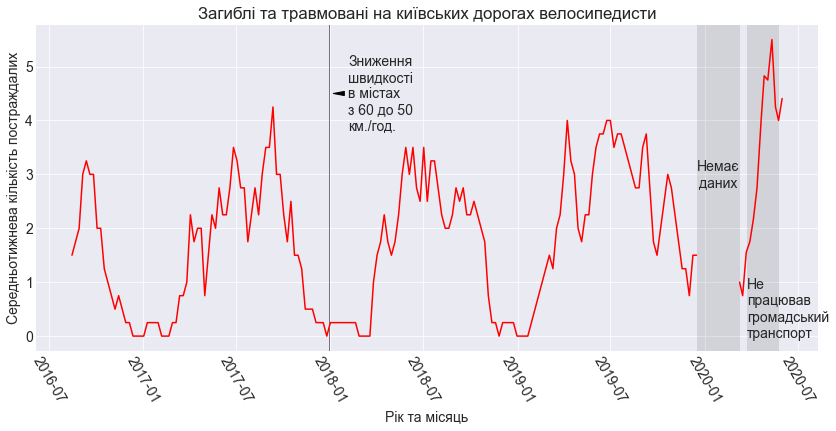

In [15]:
plt.plot(list(injuries_by_date.keys()), list(injuries_by_date.values()), color = 'red')
plt.plot(list(injuries_2020_rolling.keys()), list(injuries_2020_rolling.values()), color = 'red')
plt.xticks(rotation = -60)
inj_before, inj_after = list(injuries_by_date.keys())[-1], list(injuries_2020_rolling.keys())[0]
plt.axvspan(inj_before, inj_after, facecolor = 'black', alpha = 0.1)
plt.text(inj_before + (inj_after - inj_before) / 2, 3, 'Немає\nданих', ha = 'center', va = 'center')
plt.axvspan(transport_closed, transport_open, facecolor = 'black', alpha = 0.1)
plt.text(transport_closed, 0.5, 'Не\nпрацював\nгромадський\nтранспорт', ha = 'left', va = 'center')
speed_reduced_begin = np.datetime64(to_datetime('30.12.2017'))
speed_reduced_end = np.datetime64(to_datetime('01.01.2018'))
plt.axvspan(speed_reduced_begin, speed_reduced_end, facecolor = 'black', alpha = 0.5)
plt.annotate('Зниження\nшвидкості\nв містах\nз 60 до 50\nкм./год.', va = 'center',
             xy = (speed_reduced_end + np.timedelta64(2, 'D'), 4.5),
             xytext = (speed_reduced_end + np.timedelta64(35, 'D'), 4.5),
             arrowprops = dict(arrowstyle = 'wedge', facecolor = 'black'))
plt.title('Загиблі та травмовані на київських дорогах велосипедисти')
plt.xlabel('Рік та місяць')
plt.ylabel('Середньотижнева кількість постраждалих')

plt.show()

Це графік зміни потижневої кількості постраждалих велосипедистів залежно від часу (строго кажучи, я брав чотирьохтижневі [рухомі середні](https://uk.wikipedia.org/wiki/Рухоме_середнє) щоб зробити графіки більш гладкими). Джерело даних до $2020$ року те саме, за першу половину $2020$ - [офіційний сайт КМДА](https://kyivcity.gov.ua/dorohy_transport_ta_parkovky/dorozhniy_rukh_377411/dtp_statistika_ta_analiz_379515/). На графіку видно:

1. Велопоїздки в Києві дуже сезонні.

2. Зниження максимальної швидкості до $50$ км./год починаючи з $1$ січня $2018$ року допомогло зробити вулиці безпечнішими для велосипедистів. Кількість постраждалих змінилася не дуже сильно - з $83$ в $2017$ до $81$ в $2018$. Але тут потрібно не забувати, що загальний тренд - стрімке збільшення кількості велоДТП. Так, вже в $2019$ році їх було $116$. Більше про те, як зниження максимальної швидкості в містах покращило безпеку на дорогах, [в моєму минулому пості](https://nbviewer.jupyter.org/github/DmytroTym/urban/blob/master/Road%20safety%20measures%20analysis%20Kyiv.ipynb#Зниження-максимальної-дозволеної-швидкості).

3. На карантині в Києві [було зупинено роботу громадського транспорту](https://www.ukrinform.ua/rubric-kyiv/2901705-kiiv-zakrivae-ruh-gromadskogo-transportu.html) - це сталося $23$ березня. Після цього багато киян були змушені шукати інші способи пересування, кількість велосипедистів сильно зросла - [підрахунок Ucycle](https://www.facebook.com/ucycle.org.ua/posts/3190032474369686) показав, що їх стало більше у $2.5$ рази порівняно з весною $2019$ року. Графік показує, що за цей час кількість травмованих велосипедистів також зросла та стала рекордною. В той же час, вона не зросла пропорційно зросту кількості велосипедистів. За час, коли не працював громадський транспорт, було травмовано $34$ велосипедиста, за аналогічний період $2019$ року - $26$. Це можна вважати аргументом "за" теорію [safety in numbers](https://en.wikipedia.org/wiki/Safety_in_numbers), яка стверджує, що за однакових умов більша кількість велосипедистів означає кращу безпеку кожного окремого велосипедиста. Тобто, будь-які дії, спрямовані на збільшення кількості велосипедистів на вулицях, покращують індивідуальну безпеку кожного з них.

## Спроби зрозуміти особливості київського велоруху

Для планування веломережі важливо розуміти, як рухаються велосипедисти сьогодні. Місту поки не цікаво збирати дані про це, тому єдине, що залишається - шукати GPS-дані сторонніх організацій. Головний датасет з геоданими про велорух - [Strava Metro](https://metro.strava.com). На жаль, доступ до цих даних платний. Вони візуалізовані на [тепловій мапі](https://www.strava.com/heatmap), на яку дуже цікаво дивитись, але яка, на жаль, не дає інформації про об'єми поїздок по тим чи іншим вулицям і тому не дуже корисна для аналізу.

Натомість, я знайшов дані сервісу велошейрингу [Nextbike](https://www.nextbike.ua/uk/kyiv/), [ось вони](https://www.kaggle.com/pankrzysiu/nextbike-api-history). Візуалізація цих даних далі:

In [16]:
Kyiv_id = 192             #можна знайти в таблиці cities. тут ми відфільтровуємо лише київські станції
temp = []
for chunk in pd.read_csv('C:/Users/dmytr/Downloads/149892_766564_compressed_places.csv/places.csv', chunksize = 10000):
    temp.append(chunk.loc[chunk['cityguid'] == Kyiv_id])
data = pd.concat(temp)

guid_to_coords = {}
for _, row in data.iterrows():
    guid_to_coords[row['guid']] = (row['lat'], row['lng'])

In [ ]:
Kyiv_guids = list(data['guid'])      #після того, як маємо київські guid, можна виділити всі київські записи з головної таблиці

Kyiv_rows = []
for chunk in pd.read_csv('C:/Users/dmytr/Downloads/149892_766564_compressed_bike_list.csv/bike_list.csv', chunksize = 100000):
    Kyiv_rows.append(chunk.loc[chunk['placeguid'].isin(Kyiv_guids)])

Kyiv_bikes = pd.concat(Kyiv_rows)
Kyiv_bikes = Kyiv_bikes.sort_values(['number', 'appeared'], ascending = [True, True])

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

is_a_station = [row['name'][0:4] != 'BIKE' for _, row in data.iterrows()]
clustering = DBSCAN(eps = 0.0025, min_samples = 1).fit(data.loc[is_a_station][['lat', 'lng']])

In [ ]:
from collections import defaultdict

coords_to_cluster, cluster_to_points, cluster_to_name = {}, defaultdict(list), defaultdict(str)
for coords, name, label in zip(data.loc[is_a_station][['lat', 'lng']].to_numpy(), 
                               data.loc[is_a_station]['name'].to_numpy(), clustering.labels_):
    coords_to_cluster[tuple(coords)] = label
    cluster_to_points[label].append(coords)
    if len(cluster_to_name[label]) == 0:
        cluster_to_name[label] = name
        
cluster_to_points = {k: np.mean(pts, axis = 0) for k, pts in cluster_to_points.items()}

In [ ]:
num_of_clus = len(set(clustering.labels_))
num_of_trips, cluster_trips = [defaultdict(int) for i in range(num_of_clus)], [0] * num_of_clus 

prev = None
for _, row in Kyiv_bikes.iterrows():
    if type(prev) != type(None) and row['number'] == prev['number'] and\
    guid_to_coords[prev['placeguid']] in coords_to_cluster.keys() and\
    guid_to_coords[row['placeguid']] in coords_to_cluster.keys():
        prev_clus = coords_to_cluster[guid_to_coords[prev['placeguid']]]
        curr_clus = coords_to_cluster[guid_to_coords[row['placeguid']]]
        num_of_trips[prev_clus][curr_clus] += 1
        cluster_trips[curr_clus] += 1
    prev = row

In [ ]:
Kyiv_coords = [50.461916, 30.519283]
cycling_map = folium.Map(location = Kyiv_coords, zoom_start = 12, tiles = 'Cartodb Positron')

for i, destinations in enumerate(num_of_trips):
    for j, num in destinations.items():
        if i > j:
            #коли я пишу цей код, у branca є проблеми з кирилицею в tooltip
            #тому доводиться використовувати цю дивну конструкцію, див:
            #https://github.com/python-visualization/branca/pull/76/
            tooltip = 'Кількість поїздок від {0} до {1} - {2}<br>Кількість поїздок від {1} до {0} - {3}'.\
            format(cluster_to_name[i], cluster_to_name[j], num, num_of_trips[j][i]).\
            encode('raw_unicode_escape').decode('utf8')
            num += num_of_trips[j][i]
            folium.PolyLine(locations = [cluster_to_points[i], cluster_to_points[j]], 
                            weight = num / 50, color = 'blue', tooltip = tooltip).add_to(cycling_map)

for i, num in enumerate(cluster_trips):
    tooltip = 'Це станція (або декілька станцій) {0}<br>Кількість поїздок звідси - {1}'.\
            format(cluster_to_name[i], num).encode('raw_unicode_escape').decode('utf8')
    folium.CircleMarker(location = cluster_to_points[i], fill = 'true', radius = (num + 0.1) / 150, 
                        fill_color = 'blue', color = 'clear', tooltip = tooltip, fill_opacity = 1).add_to(cycling_map)

add_title_to_map(cycling_map, 'Поїздки на Nextbike в Києві у теплі місяці 2019')
    
cycling_map

Одна крапка на мапі - це одна станція, або декілька близьких станцій велопрокату. Лінії між крапками - поїздки між відповідними станціями. Що жирніша крапка або лінія - то більше велосипедистів користується станцією або їздить між станціями. При наведенні миші на крапки і лінії можна отримати детальнішу інформацію. 

На жаль, дані Nextbike очевидно не репрезентують всіх велопоїздок в Києві. Тому ця мапа може годитися для покращення роботи Nextbike, але не розуміння київських велотенденцій. Але я все одно її залишу, раптом комусь вона буде корисною або здасться цікавою.

Дякую за увагу!